In this notebook, we are creating a Voting Regressor, which is an ensemble method that combines the predictions of multiple regression models. In this case, it combines the predictions of a Linear Regression, Random Forest Regressor, and XGBoost Regressor.

In [1]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Instantiate individual models
model1 = LinearRegression()
model2 = RandomForestRegressor()
model3 = XGBRegressor()

# Create the ensemble model
model = VotingRegressor(estimators=[('lr', model1), ('rf', model2), ('xgb', model3)])


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.
Categorical variables encoded.
Numerical features standardized.
'SalePrice' standardized.
Explained variance ratio: 0.9513195107448541
PCA Training Time: 2.78 seconds
Training Time for RFE: 118.04 seconds
Voting Regressor Performance with PCA and RFE:
Mean Absolute Error (MAE): $14528.52
Mean Squared Error (MSE): $498350091.97


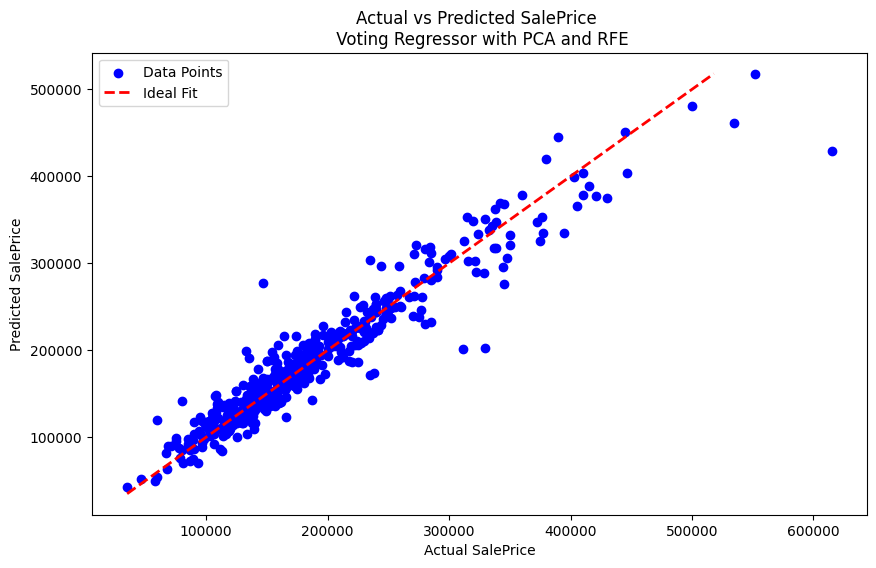

In [3]:

# Import necessary libraries

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import data_cleaning as dc
import data_preprocessing as dp
import feature_engineering as fe
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import time 

# Instantiate individual models
model1 = LinearRegression()
model2 = RandomForestRegressor()
model3 = XGBRegressor()

# Create the ensemble model
voting_model = VotingRegressor(estimators=[('lr', model1), ('rf', model2), ('xgb', model3)])

# Load and preprocess the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)

# Apply RFE
X_train_rfe, rfe = fe.apply_rfe(X_train_pca, y_train, n_features=50)
X_test_rfe = rfe.transform(X_test_pca)

# Train the Voting Regressor model
voting_model.fit(X_train_rfe, y_train)

# Make predictions
y_pred_voting = voting_model.predict(X_test_rfe)

# Un-transform the predictions back to the original scale
y_pred_voting_original = saleprice_scaler.inverse_transform(y_pred_voting.reshape(-1, 1)).flatten()
y_test_original = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Evaluate the model
mae_voting = mean_absolute_error(y_test_original, y_pred_voting_original)
mse_voting = mean_squared_error(y_test_original, y_pred_voting_original)

print("Voting Regressor Performance with PCA and RFE:")
print(f"Mean Absolute Error (MAE): ${mae_voting:.2f}")
print(f"Mean Squared Error (MSE): ${mse_voting:.2f}")

# Plot actual vs predicted for the Voting Regressor
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_voting_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_voting_original.max()], [y_test_original.min(), y_pred_voting_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Voting Regressor with PCA and RFE')
plt.legend()
plt.show()
